# Graph Neural Networks and Graph Embeddings

**Authors:** Stephanie Gomes and Sara Saad

## Project Overview

This comprehensive notebook explores graph embeddings and Graph Neural Networks (GNNs) using the Facebook social network dataset (`facebook_dataset/facebook_combined.txt`).

We focus on these tasks:
1. **Shallow Graph Embeddings**: Node2Vec and DeepWalk algorithms for learning node representations
2. **Graph Neural Networks**: GCN, GraphSAGE, and GAT architectures for node classification
3. **Link Prediction**: Predicting missing edges using learned embeddings
4. **Embedding Visualization**: Visualizing and analyzing learned representations




In [4]:
# Environment check: torch and torch_geometric
import importlib
import sys

has_torch = importlib.util.find_spec('torch') is not None
has_tg = importlib.util.find_spec('torch_geometric') is not None

print('Python executable:', sys.executable)
print('torch installed:', has_torch)
print('torch_geometric installed:', has_tg)

if not has_torch or not has_tg:
    print('\nIf you want to run the GNN cells, consider installing PyTorch and PyTorch Geometric.')
    print('\nExample CPU-only install:')
    print('  pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu')
    print('\nPyTorch Geometric:')
    print('  pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html')
    print('\nNote: networkx should already be installed.')

Python executable: /usr/bin/python3
torch installed: True
torch_geometric installed: False

If you want to run the GNN cells, consider installing PyTorch and PyTorch Geometric.

Example CPU-only install:
  pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

PyTorch Geometric:
  pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

Note: networkx should already be installed.


In [ ]:
# For Colab

!pip install "numpy>=1.24.0,<2"
!pip install networkx>=2.6.0 matplotlib>=3.4.0 seaborn>=0.11.0 pandas>=1.3.0 scipy>=1.9.0 scikit-learn>=1.0.0
!pip install node2vec>=0.4.6 gensim>=4.0.0 python-igraph>=0.9.0 jupyter>=1.0.0
!pip install torch>=2.0.0 torchvision>=0.15.0 --extra-index-url https://download.pytorch.org/whl/cpu
!pip install torch-geometric>=2.4.0

## 1. Dataset Loading and Exploration

### 1.1 Load Graph (NetworkX) and Inspect

We begin by loading the Facebook social network dataset. This dataset represents a social network where nodes are users and edges represent friendships. The graph is undirected, meaning friendships are mutual.

**Dataset Statistics:**
- **Source**: SNAP (Stanford Network Analysis Project)
- **Type**: Undirected social network
- **Nodes**: Users in the network
- **Edges**: Friendship connections

Let's load and explore the basic properties of the graph.

Nodes: 4039
Edges: 88234
Average degree: 43.69
Max degree: 1045
Min degree: 1


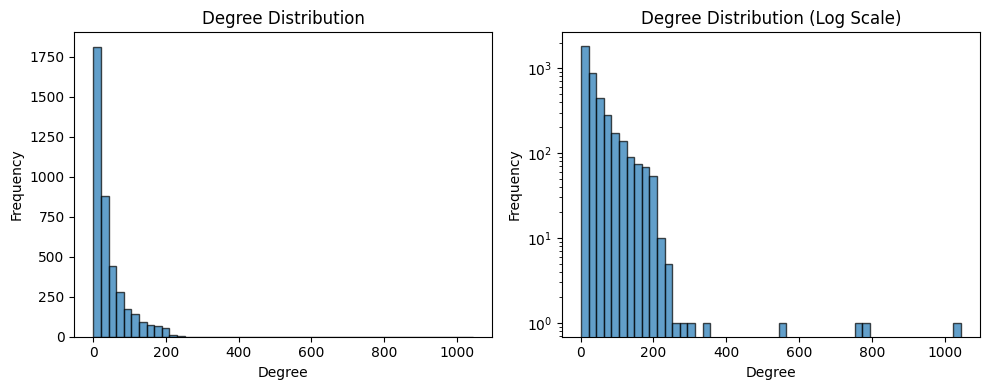

In [8]:
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Load the Facebook dataset
path = 'facebook_combined.txt'
if not os.path.exists(path):
    raise FileNotFoundError(f'Expected dataset at {path}')

G = nx.read_edgelist(path, nodetype=int)
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edges: {G.number_of_edges()}')

# Compute degree statistics
deg = dict(G.degree())
degrees = list(deg.values())
print(f'Average degree: {np.mean(degrees):.2f}')
print(f'Max degree: {np.max(degrees)}')
print(f'Min degree: {np.min(degrees)}')

# Plot degree distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(degrees, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')

plt.subplot(1, 2, 2)
plt.hist(degrees, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Degree Distribution (Log Scale)')
plt.tight_layout()
plt.show()

## 2. Shallow Graph Embeddings

We use **Node2Vec** and **DeepWalk** to learn node representations from random walks, then apply **Word2Vec (Skip-gram)** to embed nodes in a continuous vector space.


In [9]:
# Shallow embeddings: Node2Vec and Word2Vec
import warnings
warnings.filterwarnings('ignore')

from node2vec import Node2Vec
from gensim.models import Word2Vec

import numpy as np
import scipy

print("Packages loaded successfully!")
print(f"numpy version: {np.__version__}")
print(f"scipy version: {scipy.__version__}")

Packages loaded successfully!
numpy version: 1.26.4
scipy version: 1.16.3


### 2.2 Node2Vec Implementation

Node2Vec extends DeepWalk by introducing **biased random walks** that balance between:
- **BFS (Breadth-First Search)**: Explores local neighborhood structure (homophily)
- **DFS (Depth-First Search)**: Explores distant nodes (structural equivalence)

**Key Innovation**: Node2Vec uses a flexible neighborhood sampling strategy that interpolates between BFS and DFS through two parameters:

#### **Random Walk Strategy**

Given a walk that just traversed edge $(t, v)$ and now resides at node $v$, the probability of transitioning to the next node $x$ is:

$$P(c_i = x | c_{i-1} = v) = \begin{cases}
\frac{1}{p} & \text{if } d_{tx} = 0 \text{ (return to previous node)} \\
1 & \text{if } d_{tx} = 1 \text{ (stay in local neighborhood)} \\
\frac{1}{q} & \text{if } d_{tx} = 2 \text{ (explore distant nodes)}
\end{cases}$$

Where $d_{tx}$ is the shortest path distance between nodes $t$ and $x$.

#### **Parameters Explained:**

- **`p` (Return parameter)**:
  - **Low p (< 1)**: Higher probability of revisiting previous node (BFS-like, explores local structure)
  - **High p (> 1)**: Lower probability of backtracking (DFS-like, explores distant nodes)
  - **p = 1**: Uniform probability (similar to DeepWalk)

- **`q` (In-out parameter)**:
  - **Low q (< 1)**: Higher probability of moving away from previous node (DFS-like, exploration)
  - **High q (> 1)**: Higher probability of staying in local neighborhood (BFS-like, exploitation)
  - **q = 1**: Uniform probability (similar to DeepWalk)

- **`dimensions`**: Size of the learned embedding vectors (typically 64-256)
- **`walk_length`**: Number of steps in each random walk (typically 10-80)
- **`num_walks`**: Number of walks to generate per node (typically 10-100)
- **`window`**: Context window size for Skip-gram (typically 5-10)
- **`workers`**: Number of parallel workers for faster computation

#### **Algorithm Steps:**

1. **Precompute transition probabilities** for all edges based on $p$ and $q$
2. **Generate random walks** starting from each node using biased sampling
3. **Train Skip-gram model** on the generated walks to learn embeddings
4. **Extract embeddings** for each node

**Advantages over DeepWalk:**
- Can capture both homophily (similar nodes cluster) and structural equivalence (nodes with similar roles)
- More flexible exploration strategy
- Better performance on diverse graph structures

In [10]:
!pip install "numpy>=1.24.0,<2"
!pip install networkx>=2.6.0 matplotlib>=3.4.0 seaborn>=0.11.0 pandas>=1.3.0 scipy>=1.9.0 scikit-learn>=1.0.0
!pip install node2vec>=0.4.6 gensim>=4.0.0 python-igraph>=0.9.0 jupyter>=1.0.0
!pip install torch>=2.0.0 torchvision>=0.15.0 --extra-index-url https://download.pytorch.org/whl/cpu
!pip install torch-geometric>=2.4.0

In [11]:
# Node2Vec: Learn embeddings using biased random walks
print("Training Node2Vec embeddings...")
print("This may take a few minutes...")
print("\nNode2Vec Configuration:")
print("  - Dimensions: 128")
print("  - Walk length: 30")
print("  - Number of walks per node: 200")
print("  - Return parameter (p): 1.0 (moderate backtracking)")
print("  - In-out parameter (q): 1.0 (balanced exploration)")
print("  - Window size: 10")
print("  - Workers: 4 (parallel processing)")
print()

# Initialize Node2Vec with balanced parameters (p=1, q=1)
# For BFS-like behavior: p < 1, q > 1
# For DFS-like behavior: p > 1, q < 1
node2vec = Node2Vec(
    G,
    dimensions=128,      # Embedding dimension
    walk_length=30,      # Length of each random walk
    num_walks=200,       # Number of walks per node
    workers=4,           # Parallel workers
    p=1.0,               # Return parameter (1.0 = moderate backtracking)
    q=1.0                # In-out parameter (1.0 = balanced exploration)
)

# Train the model using Skip-gram
# window: Context window size for Skip-gram
# min_count: Minimum word count (nodes) to consider
# batch_words: Batch size for training
model = node2vec.fit(
    window=10,           # Context window size
    min_count=1,         # Minimum node frequency
    batch_words=4        # Batch size for training
)

# Extract embeddings for all nodes
node2vec_embeddings = {}
for node in G.nodes():
    node2vec_embeddings[node] = model.wv[str(node)]

print(f"\n✓ Node2Vec embeddings learned successfully!")
print(f"  - Total nodes: {len(node2vec_embeddings)}")
print(f"  - Embedding dimension: {len(node2vec_embeddings[0])}")
print(f"  - Vocabulary size: {len(model.wv)}")

# Display some statistics
sample_node = list(G.nodes())[0]
print(f"\nSample embedding for node {sample_node}:")
print(f"  First 10 dimensions: {node2vec_embeddings[sample_node][:10]}")
print(f"  Embedding norm: {np.linalg.norm(node2vec_embeddings[sample_node]):.4f}")

Training Node2Vec embeddings...
This may take a few minutes...

Node2Vec Configuration:
  - Dimensions: 128
  - Walk length: 30
  - Number of walks per node: 200
  - Return parameter (p): 1.0 (moderate backtracking)
  - In-out parameter (q): 1.0 (balanced exploration)
  - Window size: 10
  - Workers: 4 (parallel processing)



Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]


✓ Node2Vec embeddings learned successfully!
  - Total nodes: 4039
  - Embedding dimension: 128
  - Vocabulary size: 4039

Sample embedding for node 0:
  First 10 dimensions: [ 0.13808574 -0.19240841  0.47888196  0.3269902   0.41275722 -0.6086881
 -0.02730627  0.09069245  0.08968993  0.11071748]
  Embedding norm: 3.4376


#### **Experimenting with Different Parameter Settings**

Let's explore how different values of `p` and `q` affect the learned embeddings:

- **BFS-like (p=0.5, q=2.0)**: Focuses on local neighborhood structure
- **DFS-like (p=2.0, q=0.5)**: Emphasizes exploration of distant nodes
- **Balanced (p=1.0, q=1.0)**: Similar to DeepWalk, uniform exploration

In [12]:
# Experiment with different p and q values
print("Training Node2Vec with different parameter settings...\n")

# BFS-like: p < 1, q > 1 (explores local structure)
print("1. BFS-like (p=0.5, q=2.0): Exploring local neighborhood...")
node2vec_bfs = Node2Vec(G, dimensions=128, walk_length=30, num_walks=100, workers=4, p=0.5, q=2.0)
model_bfs = node2vec_bfs.fit(window=10, min_count=1, batch_words=4)
embeddings_bfs = {node: model_bfs.wv[str(node)] for node in G.nodes()}
print("   ✓ Completed\n")

# DFS-like: p > 1, q < 1 (explores distant nodes)
print("2. DFS-like (p=2.0, q=0.5): Exploring distant nodes...")
node2vec_dfs = Node2Vec(G, dimensions=128, walk_length=30, num_walks=100, workers=4, p=2.0, q=0.5)
model_dfs = node2vec_dfs.fit(window=10, min_count=1, batch_words=4)
embeddings_dfs = {node: model_dfs.wv[str(node)] for node in G.nodes()}
print("   ✓ Completed\n")

print("All parameter configurations trained successfully!")

Training Node2Vec with different parameter settings...

1. BFS-like (p=0.5, q=2.0): Exploring local neighborhood...


Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

   ✓ Completed

2. DFS-like (p=2.0, q=0.5): Exploring distant nodes...


Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

   ✓ Completed

All parameter configurations trained successfully!


#### **Comparing Different Parameter Settings**

Let's visualize how different parameter settings affect the learned embeddings:

Applying PCA for dimensionality reduction...
Applying t-SNE (this may take a moment)...


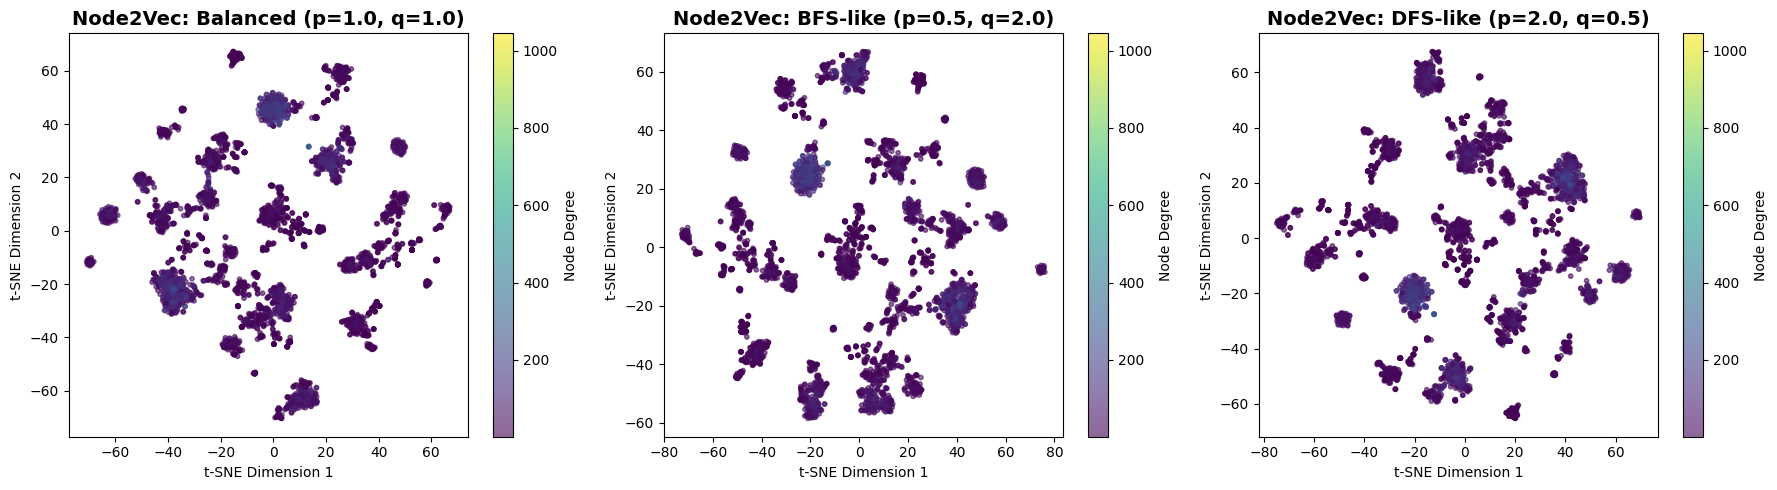


Visualization complete!

Observations:
  - Balanced (p=1, q=1): Uniform exploration, similar to DeepWalk
  - BFS-like (p=0.5, q=2.0): Nodes with similar local neighborhoods cluster together
  - DFS-like (p=2.0, q=0.5): Nodes with similar structural roles cluster together


In [13]:
# Compare embeddings from different parameter settings
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Prepare data for comparison
node_ids = sorted(G.nodes())
node_degrees = [G.degree(nid) for nid in node_ids]

# Convert embeddings to matrices
emb_matrix_balanced = np.array([node2vec_embeddings[nid] for nid in node_ids])
emb_matrix_bfs = np.array([embeddings_bfs[nid] for nid in node_ids])
emb_matrix_dfs = np.array([embeddings_dfs[nid] for nid in node_ids])

# Apply PCA for dimensionality reduction (faster computation)
print("Applying PCA for dimensionality reduction...")
pca_balanced = PCA(n_components=50)
pca_bfs = PCA(n_components=50)
pca_dfs = PCA(n_components=50)

emb_balanced_pca = pca_balanced.fit_transform(emb_matrix_balanced)
emb_bfs_pca = pca_bfs.fit_transform(emb_matrix_bfs)
emb_dfs_pca = pca_dfs.fit_transform(emb_matrix_dfs)

# Apply t-SNE
print("Applying t-SNE (this may take a moment)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

emb_balanced_2d = tsne.fit_transform(emb_balanced_pca)
emb_bfs_2d = tsne.fit_transform(emb_bfs_pca)
emb_dfs_2d = tsne.fit_transform(emb_dfs_pca)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Balanced (p=1, q=1)
scatter1 = axes[0].scatter(emb_balanced_2d[:, 0], emb_balanced_2d[:, 1],
                          c=node_degrees, cmap='viridis', alpha=0.6, s=10)
axes[0].set_title('Node2Vec: Balanced (p=1.0, q=1.0)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
plt.colorbar(scatter1, ax=axes[0], label='Node Degree')

# BFS-like (p=0.5, q=2.0)
scatter2 = axes[1].scatter(emb_bfs_2d[:, 0], emb_bfs_2d[:, 1],
                          c=node_degrees, cmap='viridis', alpha=0.6, s=10)
axes[1].set_title('Node2Vec: BFS-like (p=0.5, q=2.0)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
plt.colorbar(scatter2, ax=axes[1], label='Node Degree')

# DFS-like (p=2.0, q=0.5)
scatter3 = axes[2].scatter(emb_dfs_2d[:, 0], emb_dfs_2d[:, 1],
                          c=node_degrees, cmap='viridis', alpha=0.6, s=10)
axes[2].set_title('Node2Vec: DFS-like (p=2.0, q=0.5)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('t-SNE Dimension 1')
axes[2].set_ylabel('t-SNE Dimension 2')
plt.colorbar(scatter3, ax=axes[2], label='Node Degree')

plt.tight_layout()
plt.show()

print("\nVisualization complete!")
print("\nObservations:")
print("  - Balanced (p=1, q=1): Uniform exploration, similar to DeepWalk")
print("  - BFS-like (p=0.5, q=2.0): Nodes with similar local neighborhoods cluster together")
print("  - DFS-like (p=2.0, q=0.5): Nodes with similar structural roles cluster together")

### 2.3 DeepWalk Implementation

DeepWalk is a simpler approach that uses **uniform random walks** (equivalent to Node2Vec with p=1, q=1). It treats random walks as "sentences" and nodes as "words", then applies Word2Vec (Skip-gram) to learn embeddings.

#### **Algorithm Steps:**

1. **Generate random walks**: For each node, perform multiple uniform random walks
2. **Treat walks as sentences**: Each walk becomes a sequence of node IDs
3. **Apply Skip-gram**: Learn embeddings by predicting context nodes
4. **Extract embeddings**: Use learned word vectors as node embeddings

#### **Key Characteristics:**

- **Uniform exploration**: All neighbors have equal probability of being visited
- **Simple and efficient**: No need to precompute transition probabilities
- **Good baseline**: Often performs well on many graph types
- **Homophily-focused**: Tends to cluster nodes with similar neighborhoods

#### **Comparison with Node2Vec:**

| Aspect | DeepWalk | Node2Vec |
|--------|----------|----------|
| Walk strategy | Uniform random | Biased random (BFS/DFS balance) |
| Parameters | Fewer (walk_length, num_walks) | More (adds p, q) |
| Flexibility | Less flexible | More flexible |
| Performance | Good baseline | Often better on diverse graphs |
| Use case | Homophily-focused tasks | Both homophily and structural equivalence |

In [14]:
# DeepWalk: Uniform random walks (p=1, q=1)
print("Training DeepWalk embeddings...")
print("\nDeepWalk Configuration:")
print("  - Dimensions: 128")
print("  - Walk length: 30")
print("  - Number of walks per node: 200")
print("  - Uniform random walks (p=1.0, q=1.0)")
print("  - Window size: 10")
print("  - Workers: 4 (parallel processing)")
print()

# DeepWalk is equivalent to Node2Vec with p=1, q=1 (uniform random walks)
deepwalk = Node2Vec(
    G,
    dimensions=128,      # Embedding dimension
    walk_length=30,      # Length of each random walk
    num_walks=200,       # Number of walks per node
    workers=4,           # Parallel workers
    p=1.0,               # Return parameter = 1 (uniform)
    q=1.0                # In-out parameter = 1 (uniform)
)

# Train using Skip-gram
deepwalk_model = deepwalk.fit(
    window=10,           # Context window size
    min_count=1,         # Minimum node frequency
    batch_words=4        # Batch size for training
)

# Extract embeddings
deepwalk_embeddings = {}
for node in G.nodes():
    deepwalk_embeddings[node] = deepwalk_model.wv[str(node)]

print(f"\n✓ DeepWalk embeddings learned successfully!")
print(f"  - Total nodes: {len(deepwalk_embeddings)}")
print(f"  - Embedding dimension: {len(deepwalk_embeddings[0])}")
print(f"  - Vocabulary size: {len(deepwalk_model.wv)}")

# Display some statistics
sample_node = list(G.nodes())[0]
print(f"\nSample embedding for node {sample_node}:")
print(f"  First 10 dimensions: {deepwalk_embeddings[sample_node][:10]}")
print(f"  Embedding norm: {np.linalg.norm(deepwalk_embeddings[sample_node]):.4f}")

Training DeepWalk embeddings...

DeepWalk Configuration:
  - Dimensions: 128
  - Walk length: 30
  - Number of walks per node: 200
  - Uniform random walks (p=1.0, q=1.0)
  - Window size: 10
  - Workers: 4 (parallel processing)



Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]


✓ DeepWalk embeddings learned successfully!
  - Total nodes: 4039
  - Embedding dimension: 128
  - Vocabulary size: 4039

Sample embedding for node 0:
  First 10 dimensions: [ 0.50356054 -0.14836968  0.12550811  0.1127018   0.2982305  -0.29486194
  0.31135014  0.12700498 -0.4548159  -0.1705687 ]
  Embedding norm: 3.4496


### 2.4 Visualizing Shallow Embeddings

Let's visualize the learned embeddings using t-SNE to see if nodes with similar structural roles cluster together.

Applying PCA for dimensionality reduction...
Applying t-SNE (this may take a moment)...


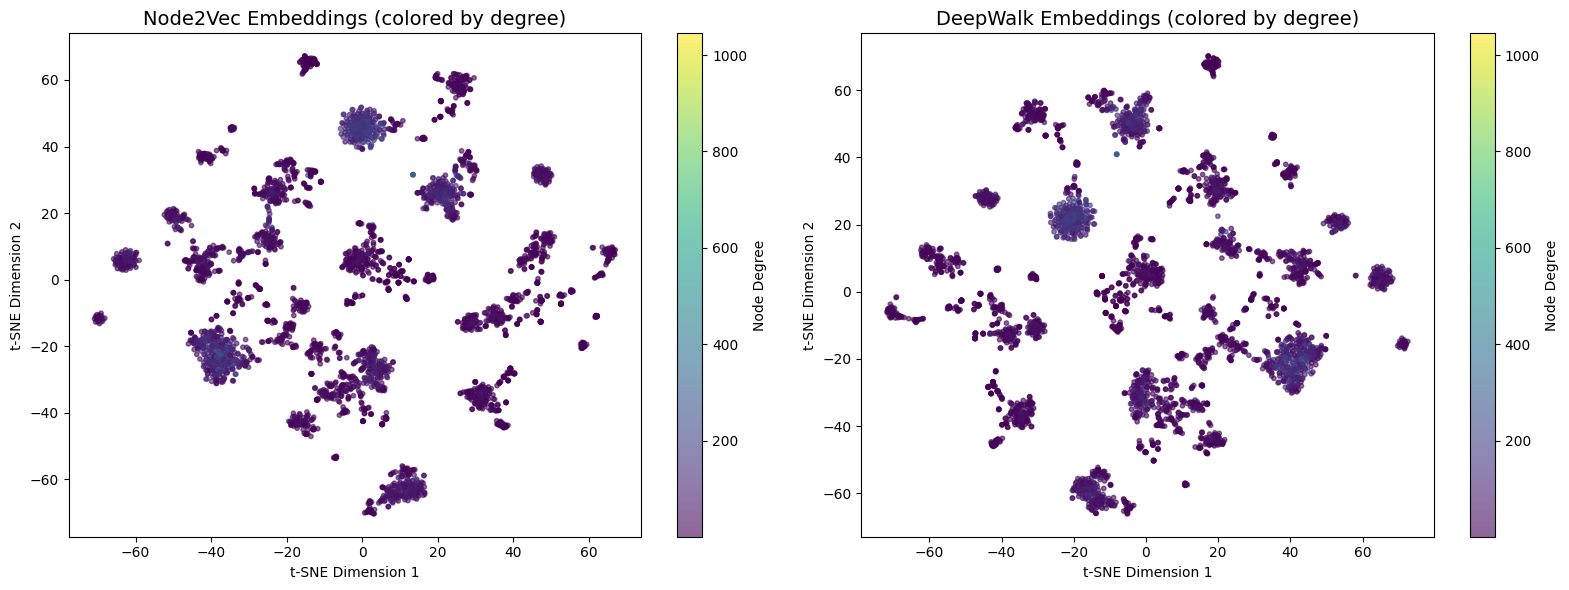

Visualization complete!


In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Convert embeddings to numpy array
node_ids = sorted(G.nodes())
node2vec_matrix = np.array([node2vec_embeddings[nid] for nid in node_ids])
deepwalk_matrix = np.array([deepwalk_embeddings[nid] for nid in node_ids])

# Get node degrees for coloring
node_degrees = [G.degree(nid) for nid in node_ids]

# Apply PCA first for faster computation
print("Applying PCA for dimensionality reduction...")
pca_node2vec = PCA(n_components=50)
pca_deepwalk = PCA(n_components=50)
node2vec_pca = pca_node2vec.fit_transform(node2vec_matrix)
deepwalk_pca = pca_deepwalk.fit_transform(deepwalk_matrix)

# Apply t-SNE
print("Applying t-SNE (this may take a moment)...")
tsne_node2vec = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_deepwalk = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

node2vec_2d = tsne_node2vec.fit_transform(node2vec_pca)
deepwalk_2d = tsne_deepwalk.fit_transform(deepwalk_pca)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Node2Vec visualization
scatter1 = axes[0].scatter(node2vec_2d[:, 0], node2vec_2d[:, 1], c=node_degrees,
                          cmap='viridis', alpha=0.6, s=10)
axes[0].set_title('Node2Vec Embeddings (colored by degree)', fontsize=14)
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
plt.colorbar(scatter1, ax=axes[0], label='Node Degree')

# DeepWalk visualization
scatter2 = axes[1].scatter(deepwalk_2d[:, 0], deepwalk_2d[:, 1], c=node_degrees,
                          cmap='viridis', alpha=0.6, s=10)
axes[1].set_title('DeepWalk Embeddings (colored by degree)', fontsize=14)
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
plt.colorbar(scatter2, ax=axes[1], label='Node Degree')

plt.tight_layout()
plt.show()

print("Visualization complete!")

### 2.5 Comparison: Node2Vec vs DeepWalk

Let's compare the performance and characteristics of both shallow embedding methods:


Comparison of Shallow Embedding Methods:
             Method   Parameters       Walk Strategy            Focus
           DeepWalk     p=1, q=1             Uniform        Homophily
Node2Vec (Balanced)     p=1, q=1             Uniform        Homophily
Node2Vec (BFS-like) p=0.5, q=2.0   Local exploration  Local structure
Node2Vec (DFS-like) p=2.0, q=0.5 Distant exploration Structural roles

Neighbor Similarity (higher = more homophily):
  DeepWalk: 0.8664
  Node2Vec (Balanced): 0.8670


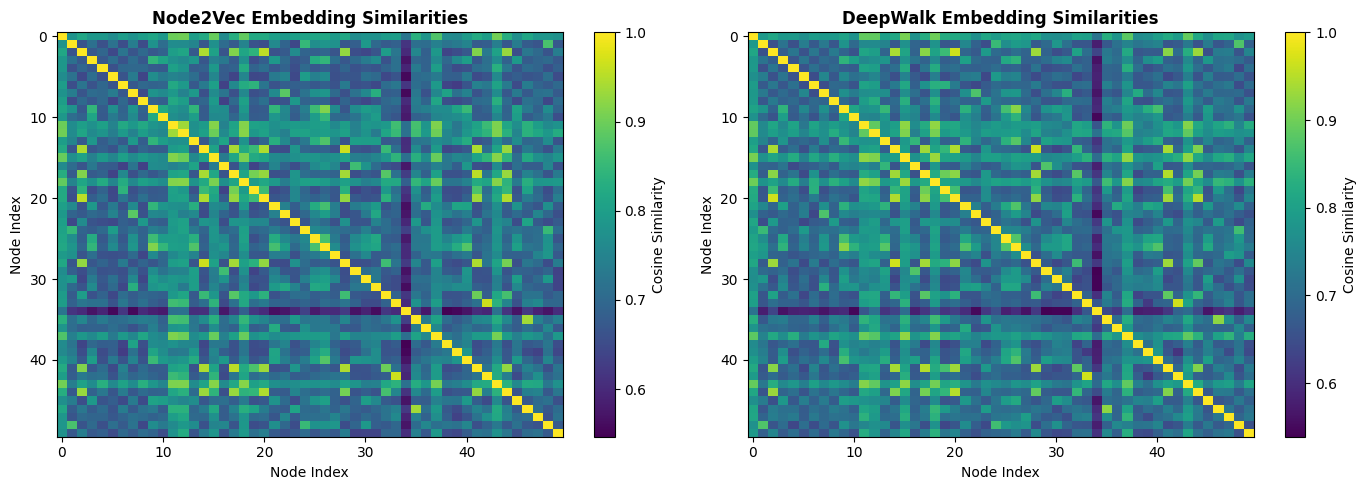


✓ Comparison analysis complete!


In [16]:
# Compare Node2Vec and DeepWalk embeddings
from sklearn.metrics.pairwise import cosine_similarity

# Select a sample of nodes for comparison
sample_nodes = list(G.nodes())[:100]
sample_degrees = [G.degree(nid) for nid in sample_nodes]

# Compute pairwise similarities
node2vec_matrix_sample = np.array([node2vec_embeddings[nid] for nid in sample_nodes])
deepwalk_matrix_sample = np.array([deepwalk_embeddings[nid] for nid in sample_nodes])

# Compute average similarity to neighbors
def compute_neighbor_similarity(embeddings_dict, graph, nodes):
    """Compute average cosine similarity to neighbors"""
    similarities = []
    for node in nodes:
        neighbors = list(graph.neighbors(node))
        if len(neighbors) > 0:
            node_emb = embeddings_dict[node]
            neighbor_embs = np.array([embeddings_dict[n] for n in neighbors[:10]])  # Sample up to 10 neighbors
            sims = cosine_similarity([node_emb], neighbor_embs)[0]
            similarities.append(np.mean(sims))
    return np.mean(similarities) if similarities else 0

node2vec_neighbor_sim = compute_neighbor_similarity(node2vec_embeddings, G, sample_nodes)
deepwalk_neighbor_sim = compute_neighbor_similarity(deepwalk_embeddings, G, sample_nodes)

# Create comparison table
comparison_data = {
    'Method': ['DeepWalk', 'Node2Vec (Balanced)', 'Node2Vec (BFS-like)', 'Node2Vec (DFS-like)'],
    'Parameters': ['p=1, q=1', 'p=1, q=1', 'p=0.5, q=2.0', 'p=2.0, q=0.5'],
    'Walk Strategy': ['Uniform', 'Uniform', 'Local exploration', 'Distant exploration'],
    'Focus': ['Homophily', 'Homophily', 'Local structure', 'Structural roles']
}

import pandas as pd
comparison_df = pd.DataFrame(comparison_data)
print("\nComparison of Shallow Embedding Methods:")
print("=" * 70)
print(comparison_df.to_string(index=False))
print("=" * 70)

print(f"\nNeighbor Similarity (higher = more homophily):")
print(f"  DeepWalk: {deepwalk_neighbor_sim:.4f}")
print(f"  Node2Vec (Balanced): {node2vec_neighbor_sim:.4f}")

# Visualize embedding space similarity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Compute similarity matrices
sim_node2vec = cosine_similarity(node2vec_matrix_sample[:50])
sim_deepwalk = cosine_similarity(deepwalk_matrix_sample[:50])

# Plot similarity heatmaps
im1 = axes[0].imshow(sim_node2vec, cmap='viridis', aspect='auto')
axes[0].set_title('Node2Vec Embedding Similarities', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Node Index')
axes[0].set_ylabel('Node Index')
plt.colorbar(im1, ax=axes[0], label='Cosine Similarity')

im2 = axes[1].imshow(sim_deepwalk, cmap='viridis', aspect='auto')
axes[1].set_title('DeepWalk Embedding Similarities', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Node Index')
axes[1].set_ylabel('Node Index')
plt.colorbar(im2, ax=axes[1], label='Cosine Similarity')

plt.tight_layout()
plt.show()

print("\n✓ Comparison analysis complete!")

## 3. Graph Neural Networks (GNNs)

### 3.1 Overview of GNNs

Graph Neural Networks learn node representations by aggregating information from neighboring nodes. Unlike shallow embeddings, GNNs:
- Use **neural networks** to learn complex feature transformations
- Can leverage **node features** in addition to graph structure
- Are **inductive**: Can generalize to unseen nodes/graphs

**Key GNN Architectures:**
1. **GCN (Graph Convolutional Network)**: Simple message passing
2. **GraphSAGE**: Sample and aggregate neighbors
3. **GAT (Graph Attention Network)**: Attention-weighted aggregation

### 3.2 Prepare Data for PyTorch Geometric

We convert the NetworkX graph to PyTorch Geometric format and create synthetic node labels based on degree for node classification tasks.

### 3.2 Prepare Data for PyTorch Geometric
Convert NetworkX graph to PyTorch Geometric format and create synthetic node labels based on degree.

In [17]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from sklearn.model_selection import train_test_split

# Convert to PyG Data object
data = from_networkx(G)

# Create synthetic node features (one-hot encoding of node IDs or random features)
num_nodes = G.number_of_nodes()
data.x = torch.eye(num_nodes, dtype=torch.float)  # One-hot encoding

# Create synthetic labels based on degree (binned into classes)
degrees_array = np.array([deg[i] for i in range(num_nodes)])
# Create 3 classes based on degree percentiles
percentiles = np.percentile(degrees_array, [33, 67])
labels = np.zeros(num_nodes, dtype=int)
labels[degrees_array >= percentiles[1]] = 2  # High degree
labels[(degrees_array >= percentiles[0]) & (degrees_array < percentiles[1])] = 1  # Medium degree
# Low degree nodes remain 0

data.y = torch.tensor(labels, dtype=torch.long)

# Create train/val/test masks
indices = np.arange(num_nodes)
train_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

print(f'\nData prepared:')
print(f'  Number of nodes: {data.num_nodes}')
print(f'  Number of edges: {data.num_edges}')
print(f'  Number of features: {data.num_node_features}')
print(f'  Number of classes: {len(torch.unique(data.y))}')
print(f'  Train nodes: {data.train_mask.sum().item()}')
print(f'  Val nodes: {data.val_mask.sum().item()}')
print(f'  Test nodes: {data.test_mask.sum().item()}')


Data prepared:
  Number of nodes: 4039
  Number of edges: 176468
  Number of features: 4039
  Number of classes: 3
  Train nodes: 2827
  Val nodes: 606
  Test nodes: 606


### 3.3 Graph Convolutional Network (GCN)
Implement and train a simple GCN for node classification.

In [18]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(
    num_features=data.num_node_features,
    hidden_channels=64,
    num_classes=len(torch.unique(data.y))
).to(device)

data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

print(f'Model initialized on device: {device}')
print(model)

Model initialized on device: cuda
GCN(
  (conv1): GCNConv(4039, 64)
  (conv2): GCNConv(64, 3)
)


In [19]:
# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function
@torch.no_grad()
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    accs = {}
    for split in ['train', 'val', 'test']:
        mask = data[f'{split}_mask']
        accs[split] = (pred[mask] == data.y[mask]).sum().item() / mask.sum().item()
    return accs

# Train the model
train_losses = []
val_accs = []

print('Training GCN...')
for epoch in range(1, 201):
    loss = train()
    train_losses.append(loss)

    if epoch % 20 == 0:
        accs = test()
        val_accs.append(accs['val'])
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, '
              f"Train: {accs['train']:.4f}, Val: {accs['val']:.4f}, Test: {accs['test']:.4f}")

# Final evaluation
final_accs = test()
print(f"\nFinal Test Accuracy: {final_accs['test']:.4f}")

Training GCN...
Epoch 020, Loss: 1.0332, Train: 0.5087, Val: 0.4125, Test: 0.4752
Epoch 040, Loss: 0.9949, Train: 0.5189, Val: 0.4109, Test: 0.4653
Epoch 060, Loss: 0.9731, Train: 0.5352, Val: 0.4125, Test: 0.4604
Epoch 080, Loss: 0.9586, Train: 0.5426, Val: 0.4224, Test: 0.4604
Epoch 100, Loss: 0.9489, Train: 0.5472, Val: 0.4224, Test: 0.4521
Epoch 120, Loss: 0.9435, Train: 0.5543, Val: 0.4241, Test: 0.4604
Epoch 140, Loss: 0.9393, Train: 0.5660, Val: 0.4274, Test: 0.4752
Epoch 160, Loss: 0.9382, Train: 0.5539, Val: 0.4125, Test: 0.4488
Epoch 180, Loss: 0.9353, Train: 0.5667, Val: 0.4340, Test: 0.4637
Epoch 200, Loss: 0.9327, Train: 0.5670, Val: 0.4175, Test: 0.4422

Final Test Accuracy: 0.4422


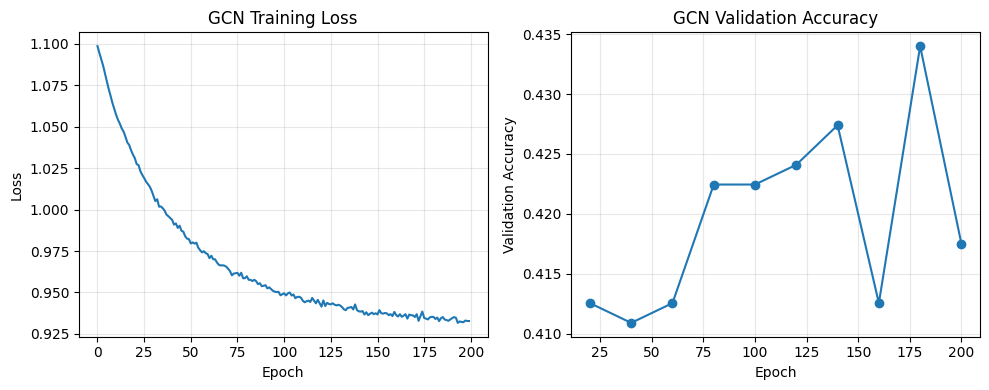

In [20]:
# Plot training progress
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GCN Training Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
epochs_logged = list(range(20, 201, 20))
plt.plot(epochs_logged, val_accs, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('GCN Validation Accuracy')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.4 GraphSAGE (Graph Sample and Aggregate)

GraphSAGE learns node embeddings by sampling and aggregating features from a node's local neighborhood. Unlike GCN, GraphSAGE:
- **Samples** a fixed-size neighborhood for each node
- Uses **learnable aggregation functions** (mean, LSTM, pooling)
- Is **inductive**: Can generate embeddings for new nodes

**Key Features:**
- Handles large graphs efficiently
- Generalizes to unseen nodes
- Uses neighbor sampling to control computational cost

In [21]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_layers=2, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()

        # First layer
        self.convs.append(SAGEConv(num_features, hidden_channels))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))

        # Output layer
        self.convs.append(SAGEConv(hidden_channels, num_classes))

        self.dropout = dropout

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.convs[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize GraphSAGE model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_sage = GraphSAGE(
    num_features=data.num_node_features,
    hidden_channels=64,
    num_classes=len(torch.unique(data.y)),
    num_layers=2
).to(device)

optimizer_sage = torch.optim.Adam(model_sage.parameters(), lr=0.01, weight_decay=5e-4)

print(f'GraphSAGE model initialized on device: {device}')
print(model_sage)

GraphSAGE model initialized on device: cuda
GraphSAGE(
  (convs): ModuleList(
    (0): SAGEConv(4039, 64, aggr=mean)
    (1): SAGEConv(64, 3, aggr=mean)
  )
)


In [24]:
# Training function for GraphSAGE
def train_sage():
    model_sage.train()
    optimizer_sage.zero_grad()
    out = model_sage(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_sage.step()
    return loss.item()

# Evaluation function for GraphSAGE
@torch.no_grad()
def test_sage():
    model_sage.eval()
    out = model_sage(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = {}
    for split in ['train', 'val', 'test']:
        mask = data[f'{split}_mask']
        accs[split] = (pred[mask] == data.y[mask]).sum().item() / mask.sum().item()
    return accs

# Train GraphSAGE
print('Training GraphSAGE...')
train_losses_sage = []
val_accs_sage = []

for epoch in range(1, 201):
    loss = train_sage()
    train_losses_sage.append(loss)

    if epoch % 20 == 0:
        accs = test_sage()
        val_accs_sage.append(accs['val'])
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, '
              f"Train: {accs['train']:.4f}, Val: {accs['val']:.4f}, Test: {accs['test']:.4f}")

# Final evaluation
final_accs_sage = test_sage()
print(f"\nFinal GraphSAGE Test Accuracy: {final_accs_sage['test']:.4f}")

Training GraphSAGE...
Epoch 020, Loss: 0.3826, Train: 0.9975, Val: 0.4439, Test: 0.4488
Epoch 040, Loss: 0.1714, Train: 1.0000, Val: 0.4620, Test: 0.4736
Epoch 060, Loss: 0.1193, Train: 1.0000, Val: 0.4389, Test: 0.4736
Epoch 080, Loss: 0.0998, Train: 1.0000, Val: 0.4307, Test: 0.4769
Epoch 100, Loss: 0.0880, Train: 1.0000, Val: 0.4505, Test: 0.4917
Epoch 120, Loss: 0.0756, Train: 1.0000, Val: 0.4488, Test: 0.4851
Epoch 140, Loss: 0.0730, Train: 1.0000, Val: 0.4488, Test: 0.4752
Epoch 160, Loss: 0.0654, Train: 1.0000, Val: 0.4472, Test: 0.4851
Epoch 180, Loss: 0.0609, Train: 1.0000, Val: 0.4406, Test: 0.4818
Epoch 200, Loss: 0.0583, Train: 1.0000, Val: 0.4521, Test: 0.4769

Final GraphSAGE Test Accuracy: 0.4769


### 3.5 Graph Attention Network (GAT)

GAT uses attention mechanisms to assign different importance to different neighbors when aggregating features. The attention mechanism allows the model to:

- **Focus** on more important neighbors
- **Learn** different attention patterns for different nodes
- **Handle** variable-sized neighborhoods naturally

**Attention Mechanism:**
$$\alpha_{ij} = \frac{\exp(\text{LeakyReLU}(\mathbf{a}^T [\mathbf{W}h_i || \mathbf{W}h_j]))}{\sum_{k \in \mathcal{N}_i} \exp(\text{LeakyReLU}(\mathbf{a}^T [\mathbf{W}h_i || \mathbf{W}h_k]))}$$

Where $\alpha_{ij}$ is the attention weight from node $j$ to node $i$.

In [25]:
from torch_geometric.nn import GATConv

class GAT(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_heads=8, dropout=0.5):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * num_heads, num_classes, heads=1, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize GAT model
model_gat = GAT(
    num_features=data.num_node_features,
    hidden_channels=8,
    num_classes=len(torch.unique(data.y)),
    num_heads=8
).to(device)

optimizer_gat = torch.optim.Adam(model_gat.parameters(), lr=0.005, weight_decay=5e-4)

print(f'GAT model initialized on device: {device}')
print(model_gat)

GAT model initialized on device: cuda
GAT(
  (conv1): GATConv(4039, 8, heads=8)
  (conv2): GATConv(64, 3, heads=1)
)


In [27]:
# Training function for GAT
def train_gat():
    model_gat.train()
    optimizer_gat.zero_grad()
    out = model_gat(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_gat.step()
    return loss.item()

# Evaluation function for GAT
@torch.no_grad()
def test_gat():
    model_gat.eval()
    out = model_gat(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = {}
    for split in ['train', 'val', 'test']:
        mask = data[f'{split}_mask']
        accs[split] = (pred[mask] == data.y[mask]).sum().item() / mask.sum().item()
    return accs

# Train GAT
print('Training GAT...')
train_losses_gat = []
val_accs_gat = []

for epoch in range(1, 201):
    loss = train_gat()
    train_losses_gat.append(loss)

    if epoch % 20 == 0:
        accs = test_gat()
        val_accs_gat.append(accs['val'])
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, '
              f"Train: {accs['train']:.4f}, Val: {accs['val']:.4f}, Test: {accs['test']:.4f}")

# Final evaluation
final_accs_gat = test_gat()
print(f"\nFinal GAT Test Accuracy: {final_accs_gat['test']:.4f}")

Training GAT...
Epoch 020, Loss: 1.0398, Train: 0.4935, Val: 0.4274, Test: 0.4868
Epoch 040, Loss: 1.0097, Train: 0.5126, Val: 0.4323, Test: 0.4835
Epoch 060, Loss: 0.9978, Train: 0.5210, Val: 0.4356, Test: 0.4818
Epoch 080, Loss: 0.9903, Train: 0.5246, Val: 0.4422, Test: 0.4868
Epoch 100, Loss: 0.9792, Train: 0.5313, Val: 0.4439, Test: 0.4752
Epoch 120, Loss: 0.9825, Train: 0.5352, Val: 0.4472, Test: 0.4637
Epoch 140, Loss: 0.9746, Train: 0.5419, Val: 0.4356, Test: 0.4653
Epoch 160, Loss: 0.9769, Train: 0.5490, Val: 0.4472, Test: 0.4521
Epoch 180, Loss: 0.9696, Train: 0.5433, Val: 0.4422, Test: 0.4620
Epoch 200, Loss: 0.9635, Train: 0.5419, Val: 0.4290, Test: 0.4587

Final GAT Test Accuracy: 0.4587


### 3.6 Comparison of GNN Architectures

Let's compare the performance of different GNN architectures on the node classification task.

\nModel Comparison:
    Model  Train Accuracy  Val Accuracy  Test Accuracy
      GCN        0.567032      0.417492       0.442244
GraphSAGE        1.000000      0.452145       0.476898
      GAT        0.541917      0.429043       0.458746


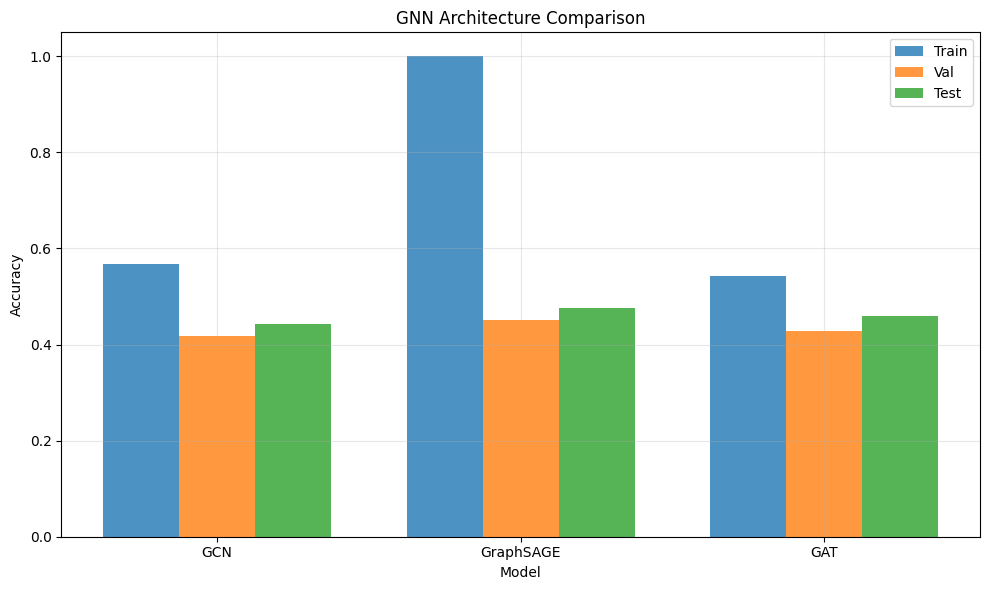

In [28]:
# Compare all GNN models
import pandas as pd

comparison_data = {
    'Model': ['GCN', 'GraphSAGE', 'GAT'],
    'Train Accuracy': [
        final_accs['train'],
        final_accs_sage['train'],
        final_accs_gat['train']
    ],
    'Val Accuracy': [
        final_accs['val'],
        final_accs_sage['val'],
        final_accs_gat['val']
    ],
    'Test Accuracy': [
        final_accs['test'],
        final_accs_sage['test'],
        final_accs_gat['test']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\\nModel Comparison:")
print(comparison_df.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.25

ax.bar(x - width, comparison_df['Train Accuracy'], width, label='Train', alpha=0.8)
ax.bar(x, comparison_df['Val Accuracy'], width, label='Val', alpha=0.8)
ax.bar(x + width, comparison_df['Test Accuracy'], width, label='Test', alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('GNN Architecture Comparison')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Link Prediction

### 4.1 Overview

Link prediction aims to predict missing or future edges in a graph. We can use learned embeddings to:
- Compute similarity scores between node pairs
- Predict whether an edge should exist between two nodes
- Evaluate using metrics like AUC-ROC

**Approach:**
1. Learn node embeddings using GNNs or shallow methods
2. For each node pair, compute embedding similarity
3. Use similarity scores to predict links
4. Evaluate on held-out edges

### 4.2 Link Prediction with GCN Embeddings

We'll use the learned GCN embeddings to predict links by computing cosine similarity between node embeddings.

In [29]:
from torch_geometric.utils import negative_sampling, train_test_split_edges

# Split edges into train/val/test
data_lp = data.clone()
data_lp = train_test_split_edges(data_lp, val_ratio=0.1, test_ratio=0.1)

print('Link prediction data split:')
print(f'  Train edges: {data_lp.train_pos_edge_index.size(1)}')
print(f'  Val edges: {data_lp.val_pos_edge_index.size(1)}')
print(f'  Test edges: {data_lp.test_pos_edge_index.size(1)}')

Link prediction data split:
  Train edges: 141176
  Val edges: 8823
  Test edges: 8823


In [30]:
from torch_geometric.nn import GCNConv

class LinkPredGCN(nn.Module):
    def __init__(self, num_features, hidden_channels, out_channels):
        super(LinkPredGCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        # Dot product of node embeddings
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return z

# Initialize link prediction model
lp_model = LinkPredGCN(
    num_features=data.num_node_features,
    hidden_channels=128,
    out_channels=64
).to(device)

lp_optimizer = torch.optim.Adam(lp_model.parameters(), lr=0.01)

print('Link Prediction Model initialized')
print(lp_model)

Link Prediction Model initialized
LinkPredGCN(
  (conv1): GCNConv(4039, 128)
  (conv2): GCNConv(128, 64)
)


In [31]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

# Prepare link prediction dataset
edges = list(G.edges())
non_edges = []
nodes_list = list(G.nodes())

# Sample negative edges (non-existent edges)
np.random.seed(42)
while len(non_edges) < len(edges):
    u, v = np.random.choice(nodes_list, 2, replace=False)
    if (u, v) not in G.edges() and (v, u) not in G.edges():
        non_edges.append((u, v))

# Split edges and non-edges
train_edges, test_edges = train_test_split(edges, test_size=0.2, random_state=42)
train_non_edges, test_non_edges = train_test_split(non_edges[:len(edges)], test_size=0.2, random_state=42)

print(f"Train edges: {len(train_edges)}, Test edges: {len(test_edges)}")
print(f"Train non-edges: {len(train_non_edges)}, Test non-edges: {len(test_non_edges)}")

# Compute cosine similarity for link prediction using Node2Vec
def compute_similarity(embeddings, node1, node2):
    emb1 = embeddings[node1]
    emb2 = embeddings[node2]
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

# Evaluate Node2Vec embeddings
def evaluate_embeddings(embeddings, test_pos, test_neg):
    scores_pos = [compute_similarity(embeddings, u, v) for u, v in test_pos]
    scores_neg = [compute_similarity(embeddings, u, v) for u, v in test_neg]

    y_true = [1] * len(scores_pos) + [0] * len(scores_neg)
    y_scores = scores_pos + scores_neg

    auc = roc_auc_score(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    return auc, ap

# Evaluate Node2Vec
node2vec_auc, node2vec_ap = evaluate_embeddings(node2vec_embeddings, test_edges, test_non_edges)
print(f"\nNode2Vec Link Prediction:")
print(f"  AUC-ROC: {node2vec_auc:.4f}")
print(f"  Average Precision: {node2vec_ap:.4f}")

# Evaluate DeepWalk
deepwalk_auc, deepwalk_ap = evaluate_embeddings(deepwalk_embeddings, test_edges, test_non_edges)
print(f"\nDeepWalk Link Prediction:")
print(f"  AUC-ROC: {deepwalk_auc:.4f}")
print(f"  Average Precision: {deepwalk_ap:.4f}")

Train edges: 70587, Test edges: 17647
Train non-edges: 70587, Test non-edges: 17647

Node2Vec Link Prediction:
  AUC-ROC: 0.9925
  Average Precision: 0.9903

DeepWalk Link Prediction:
  AUC-ROC: 0.9924
  Average Precision: 0.9902


### 4.3 Link Prediction Evaluation

We compare link prediction performance across different embedding methods:
1. **Shallow embeddings** (Node2Vec, DeepWalk): Use cosine similarity
2. **GNN embeddings**: Use learned node representations

The evaluation uses AUC-ROC and Average Precision metrics.

In [32]:
from sklearn.metrics import roc_auc_score

def train_link_pred():
    lp_model.train()
    lp_optimizer.zero_grad()

    z = lp_model.encode(data_lp.x, data_lp.train_pos_edge_index)

    # Positive edges
    pos_edge_index = data_lp.train_pos_edge_index
    pos_out = lp_model.decode(z, pos_edge_index)

    # Negative sampling
    neg_edge_index = negative_sampling(
        edge_index=data_lp.train_pos_edge_index,
        num_nodes=data_lp.num_nodes,
        num_neg_samples=pos_edge_index.size(1)
    )
    neg_out = lp_model.decode(z, neg_edge_index)

    # Binary cross-entropy loss
    pos_loss = F.binary_cross_entropy_with_logits(pos_out, torch.ones_like(pos_out))
    neg_loss = F.binary_cross_entropy_with_logits(neg_out, torch.zeros_like(neg_out))
    loss = pos_loss + neg_loss

    loss.backward()
    lp_optimizer.step()

    return loss.item()

@torch.no_grad()
def test_link_pred():
    lp_model.eval()
    z = lp_model.encode(data_lp.x, data_lp.train_pos_edge_index)

    results = {}

    for split in ['val', 'test']:
        pos_edge_index = data_lp[f'{split}_pos_edge_index']
        neg_edge_index = data_lp[f'{split}_neg_edge_index']

        pos_pred = torch.sigmoid(lp_model.decode(z, pos_edge_index))
        neg_pred = torch.sigmoid(lp_model.decode(z, neg_edge_index))

        pred = torch.cat([pos_pred, neg_pred]).cpu().numpy()
        y_true = torch.cat([
            torch.ones(pos_pred.size(0)),
            torch.zeros(neg_pred.size(0))
        ]).cpu().numpy()

        results[split] = roc_auc_score(y_true, pred)

    return results

# Train link prediction model
print('Training Link Prediction Model...')
for epoch in range(1, 201):
    loss = train_link_pred()

    if epoch % 20 == 0:
        aucs = test_link_pred()
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Val AUC: {aucs['val']:.4f}, Test AUC: {aucs['test']:.4f}")

# Final evaluation
final_aucs = test_link_pred()
print(f"\nFinal Link Prediction Test AUC: {final_aucs['test']:.4f}")

Training Link Prediction Model...
Epoch 020, Loss: 0.8468, Val AUC: 0.9775, Test AUC: 0.9799
Epoch 040, Loss: 0.7875, Val AUC: 0.9866, Test AUC: 0.9881
Epoch 060, Loss: 0.7644, Val AUC: 0.9885, Test AUC: 0.9899
Epoch 080, Loss: 0.7627, Val AUC: 0.9888, Test AUC: 0.9905
Epoch 100, Loss: 0.7578, Val AUC: 0.9894, Test AUC: 0.9910
Epoch 120, Loss: 0.7516, Val AUC: 0.9897, Test AUC: 0.9912
Epoch 140, Loss: 0.7468, Val AUC: 0.9900, Test AUC: 0.9916
Epoch 160, Loss: 0.7466, Val AUC: 0.9905, Test AUC: 0.9918
Epoch 180, Loss: 0.7444, Val AUC: 0.9908, Test AUC: 0.9921
Epoch 200, Loss: 0.7432, Val AUC: 0.9908, Test AUC: 0.9923

Final Link Prediction Test AUC: 0.9923


### 4.4 Visualize Embeddings
Use t-SNE to visualize the learned node embeddings.

Computing t-SNE (this may take a moment)...


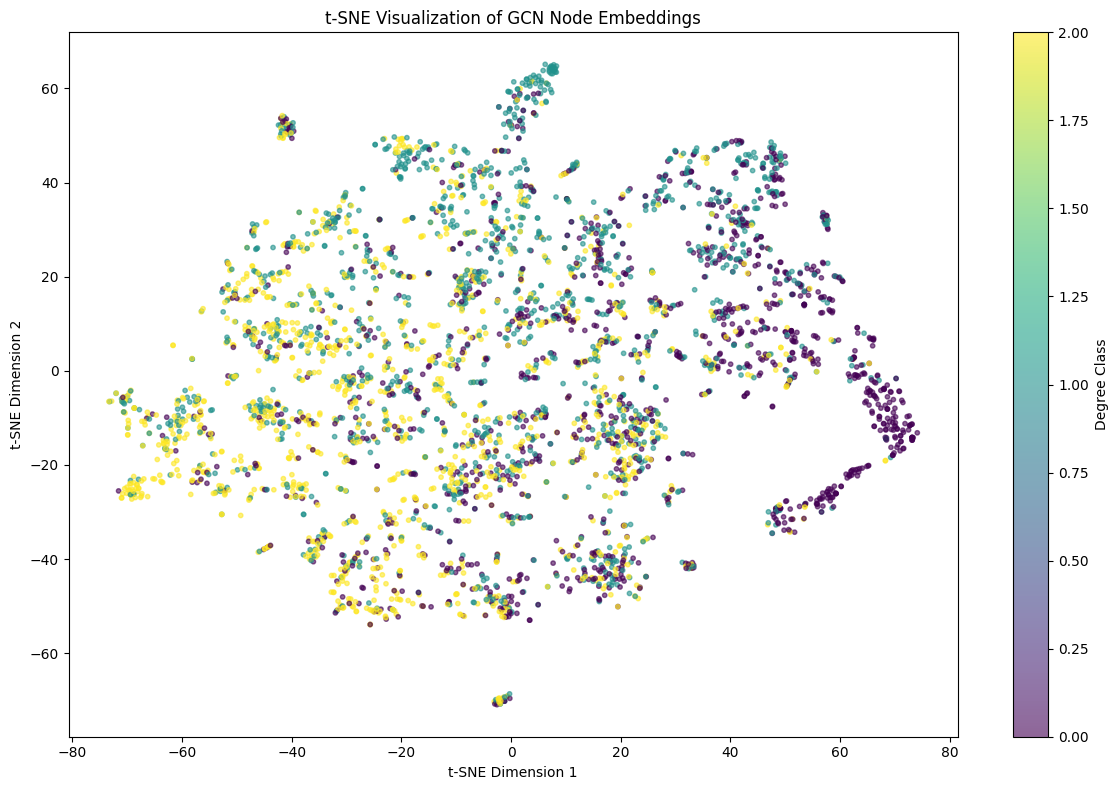

Visualization complete!


In [33]:
from sklearn.manifold import TSNE

# Get embeddings from the GCN model
model.eval()
with torch.no_grad():
    embeddings = model.conv1(data.x, data.edge_index).cpu().numpy()

# Apply t-SNE
print('Computing t-SNE (this may take a moment)...')
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=data.y.cpu().numpy(),
    cmap='viridis',
    alpha=0.6,
    s=10
)
plt.colorbar(scatter, label='Degree Class')
plt.title('t-SNE Visualization of GCN Node Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

print('Visualization complete!')

## 5. Summary and Conclusions

### 5.1 Project Summary

This comprehensive notebook explored graph embeddings and Graph Neural Networks using the Facebook social network dataset. The project covered:

#### **Shallow Graph Embeddings:**
1. **Node2Vec**: Learned node embeddings using biased random walks (balancing BFS and DFS)
2. **DeepWalk**: Learned embeddings using uniform random walks
3. **Visualization**: Analyzed embeddings using t-SNE to understand learned representations

#### **Graph Neural Networks:**
1. **GCN (Graph Convolutional Network)**: Message passing with normalized adjacency matrix
2. **GraphSAGE**: Sample and aggregate neighbors for inductive learning
3. **GAT (Graph Attention Network)**: Attention-weighted neighbor aggregation
4. **Comparison**: Evaluated all three architectures on node classification

#### **Link Prediction:**
1. **Shallow Embeddings**: Used cosine similarity with Node2Vec/DeepWalk embeddings
2. **GNN Embeddings**: Used learned GCN embeddings for link prediction
3. **Evaluation**: Compared methods using AUC-ROC and Average Precision

### 5.2 Key Findings

- **Shallow embeddings** (Node2Vec, DeepWalk) provide efficient node representations without neural networks
- **GNNs** leverage both graph structure and node features for richer representations
- **GraphSAGE** offers better scalability for large graphs through neighbor sampling
- **GAT** uses attention to focus on important neighbors during aggregation
- **Link prediction** benefits from both shallow and deep embedding methods

### 5.3 Applications

The techniques demonstrated in this notebook can be applied to:
- **Social network analysis**: Friend recommendation, community detection
- **Recommendation systems**: Product/user similarity
- **Knowledge graphs**: Entity relationship prediction
- **Biological networks**: Protein-protein interaction prediction
- **Citation networks**: Paper recommendation

### 5.4 Future Work

Potential extensions:
- Experiment with different GNN architectures (GIN, Graph Transformer)
- Explore heterogeneous graphs with multiple node/edge types
- Apply to temporal graphs with time-evolving structure
- Investigate graph-level tasks (graph classification, regression)
- Optimize hyperparameters for better performance

---

